# Library Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from wordcloud import WordCloud

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPool1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import itertools

# Exploring Fake News

In [ ]:
dataset = pd.read_csv("/content/drive/MyDrive/research/totaldata.csv")

In [ ]:
dataset.head()

,Unnamed: 0,articleID,content,headline,label
0,0,1,গত ১৭ সেপ্টেম্বর বাংলাদেশ কৃষি বিশ্ববিদ্যালয়ে ...,"হট্টগোল করায় বাকৃবিতে দুইজন বরখাস্ত, ৬ জনকে শোকজ",1
1,1,2,বাংলাদেশের বৃহৎ শ্রমবাজার মালয়েশিয়ায় আবার শ্রম...,মালয়েশিয়ায় কর্মী পাঠানোর ব্যবস্থা নেয়ার সুপারিশ,1
2,2,3,নরসিংদীর মনোহরদীতে প্রেমের প্রস্তাবে রাজি না হ...,প্রেমের প্রস্তাবে রাজি না হওয়ায় স্কুলছাত্রীকে ...,1
3,3,4,সুপ্রিম কোর্টের হাইকোর্ট বিভাগের বিচারপতি আহমে...,মেডিয়েশনই মামলাজট নিরসনের পথ : বিচারপতি আহমেদ ...,1
4,4,5,মাদারীপুর সদরের উপজেলার লেকেরপাড়ে একটি বেসরকার...,টকশোতে বক্তব্য দিতে গিয়ে জাপা নেতার মৃত্যু,1


In [ ]:
#Counting by Subjects 
#for key,count in fake.subject.value_counts().iteritems():
#    print(f"{key}:\t{count}")
    
#Getting Total Rows
#print(f"Total Records:\t{fake.shape[0]}")

In [ ]:
#plt.figure(figsize=(8,5))
#sns.countplot("subject", data=fake)
#plt.show()

In [ ]:
import nltk
#nltk.download('stopwords')
stopWords = []
with open('/content/drive/MyDrive/research/bengali', 'r', encoding="utf8") as f:
    for row in f:  # iterate over the rows in the file
        row = row.replace("\n", "")
        stopWords.append(row)

In [ ]:
!pip install bnltk

# Exploring Real news

### Difference in Text
Real news seems to have source of publication which is not present in fake news set

Looking at the data:
- most of text contains reuters information such as "**WASHINGTON (Reuters)**".
- Some text are tweets from Twitter 
- Few text do not contain any publication info

# Cleaning Data
Removing Reuters or Twitter Tweet information from the text 

- Text can be splitted only once at " - " which is always present after mentioning source of publication, this gives us publication part and text part
- If we do not get text part, this means publication details was't given for that record
- The Twitter tweets always have same source, a long text of max 259 characters 

In [ ]:
#First Creating list of index that do not have publication part
#unknown_publishers = []
#for index,row in enumerate(real.text.values):
#    try:
#        record = row.split(" -", maxsplit=1)
#        #if no text part is present, following will give error
#        record[1]
        #if len of piblication part is greater than 260
        #following will give error, ensuring no text having "-" in between is counted
#        assert(len(record[0]) < 260)
#    except:
#        unknown_publishers.append(index)

In [ ]:
#Thus we have list of indices where publisher is not mentioned
#lets check
#real.iloc[unknown_publishers].text
#true, they do not have text like "WASHINGTON (Reuters)"

While looking at texts that do not contain publication info such as which reuter, we noticed one thing.

**Text at index 8970 is empty**

In [ ]:
#real.iloc[8970]
#yep empty
#will remove this soon

In [ ]:
#Seperating Publication info, from actual text
#publisher = []
#tmp_text = []
#for index,row in enumerate(real.text.values):
#    if index in unknown_publishers:
#        #Add unknown of publisher not mentioned
#        tmp_text.append(row)
#        
#        publisher.append("Unknown")
#        continue
#    record = row.split(" -", maxsplit=1)
#    publisher.append(record[0])
#    tmp_text.append(record[1])

In [ ]:
#Replace existing text column with new text
#add seperate column for publication info
#real["publisher"] = publisher
#real["text"] = tmp_text

#del publisher, tmp_text, record, unknown_publishers

In [ ]:
#real.head()

New column called "Publisher" has been added.


In [ ]:
#checking for rows with empty text like row:8970
#[index for index,text in enumerate(real.text.values) if str(text).strip() == '']
#seems only one :)

In [ ]:
#dropping this record
#real = real.drop(8970, axis=0)

In [ ]:
# checking for the same in fake news
#empty_fake_index = [index for index,text in enumerate(fake.text.values) if str(text).strip() == '']
#print(f"No of empty rows: {len(empty_fake_index)}")
#fake.iloc[empty_fake_index].tail()

**630 Rows in Fake news with empty text**

Also noticed fake news have a lot of CPATIAL-CASES. Could preserve Cases of letters, but as we are using Google's pretrained word2vec vectors later on, which haswell-formed lower cases word. We will contert to lower case.

The text for these rows seems to be present in title itself. Lets merge title and text to solve these cases.

In [ ]:
#Looking at publication Information
# Checking if Some part of text has been included as publisher info... No such cases it seems :)

# for name,count in real.publisher.value_counts().iteritems():
#     print(f"Name: {name}\nCount: {count}\n")

In [ ]:
#Getting Total Rows
#print(f"Total Records:\t{real.shape[0]}")

#Counting by Subjects 
#for key,count in real.subject.value_counts().iteritems():
#  print(f"{key}:\t{count}")

In [ ]:
#sns.countplot(x="subject", data=real)
#plt.show()

# Preprocessing Text

In [ ]:
# Adding class Information
#real["class"] = 1
#fake["class"] = 0

In [ ]:
#Combining Title and Text
dataset["text"] = dataset["content"] + " " + dataset["headline"]

In [ ]:
# Subject is diffrent for real and fake thus dropping it
# Aldo dropping Date, title and Publication Info of real
#real = real.drop(["subject", "date","title",  "publisher"], axis=1)
#fake = fake.drop(["subject", "date", "title"], axis=1)
dataset = dataset.drop(["Unnamed: 0", "articleID", "headline", "content"], axis=1)

In [ ]:
#Combining both into new dataframe
#data = real.append(fake, ignore_index=True)
#del real, fake

In [ ]:
# Download following if not downloaded in local machine

# nltk.download('stopwords')
# nltk.download('punkt')

Removing StopWords, Punctuations and single-character words

In [ ]:
import nltk
nltk.download('punkt')
from bnltk.tokenize import Tokenizers

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
y = dataset["label"].values
#Converting X to format acceptable by gensim, removing annd punctuation stopwords in the process
X = []
#stop_words = set(nltk.corpus.stopwords.words("english"))
#tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
tokenizer = Tokenizers()
for par in dataset["text"].values:
    tmp = []
    #sentences = nltk.sent_tokenize(par)
#    for sent in sentences:
    tokens = tokenizer.bn_word_tokenizer(par)
    filtered_words = [w.strip() for w in tokens if w not in stopWords and len(w) > 1]
    tmp.extend(filtered_words)
    X.append(tmp)

In [ ]:
def plot_confusion_matrix(cm,classes,normalize=False,title='Confusion Matrix', cmap = plt.cm.Greens):
    plt.imshow(cm,interpolation = 'nearest',cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks,classes,rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
        print("Normalized CM")
    else:
        print("CM not normalized")
        
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Vectorization -- Word2Vec

Word2Vec is one of the most popular technique to learn word embeddings using shallow neural network. It was developed by Tomas Mikolov in 2013 at Google.

Word embedding is the most popular representation of document vocabulary. It is capable of capturing context of a word in a document, semantic and syntactic similarity, relation with other words, etc.

[Here](https://towardsdatascience.com/introduction-to-word-embedding-and-word2vec-652d0c2060fa) is a nice article about it.




#### Let's create and check our own Word2Vec model with **gensim**

In [ ]:
import gensim

In [ ]:
#Dimension of vectors we are generating
EMBEDDING_DIM = 100

#Creating Word Vectors by Word2Vec Method (takes time...)
w2v_model = gensim.models.Word2Vec(sentences=X, size=EMBEDDING_DIM, window=5, min_count=1)

In [ ]:
#vocab size
len(w2v_model.wv.vocab)

#We have now represented each of 122248 words by a 100dim vector.

125598

### Exploring Vectors

Lets checkout these vectors

In [ ]:
#see a sample vector for random word, lets say সুপ্রিম
w2v_model["সুপ্রিম"]

array([ 0.90750074, -1.4755845 , -2.572456  ,  2.8242438 , -0.86491394,
        0.6444068 ,  1.7847822 , -0.13165455,  0.11252116,  0.5189889 ,
       -2.8908105 ,  0.30107132,  0.17667034, -0.33088368,  0.37112138,
        0.01856638,  1.7828307 ,  0.75651205, -0.6888059 ,  1.4567609 ,
        0.6633846 ,  1.142321  ,  0.01311825, -1.073162  ,  0.45005718,
        0.18277425, -1.1440268 ,  1.5136646 ,  0.01842755, -0.98905665,
       -0.3694203 , -1.3922346 ,  0.9030151 , -0.37200373, -1.00134   ,
        0.0522076 ,  0.1176045 ,  0.03449881,  1.2026168 ,  0.97143215,
        0.37414572, -0.07951898, -1.5175784 ,  0.18149206,  0.52065235,
        1.0199656 , -0.02823722,  0.89417154,  0.05752806,  0.7380109 ,
        0.5258152 ,  0.13869426, -0.9588831 , -0.50009894, -1.0954757 ,
        2.698482  , -0.86620164, -0.3126413 , -1.1487119 ,  0.8589577 ,
        0.00621035,  2.1597288 , -1.5139424 ,  1.515407  ,  2.048537  ,
        1.4232441 ,  0.3698083 ,  1.3593785 , -0.9515993 ,  0.48

In [ ]:
w2v_model.wv.most_similar("সেপ্টেম্বর")

[('সেপ্টম্বর', 0.7795805335044861),
 ('২৪নং', 0.7410720586776733),
 ('রিলেন', 0.7220916748046875),
 ('গড়লো', 0.7192182540893555),
 ('অভিযানও', 0.7157152891159058),
 ('ধাঁধাটি', 0.705436110496521),
 ('খননকাজের', 0.698965311050415),
 ('প্রসারসহ', 0.6886398792266846),
 ('ডায়ানাসহ', 0.6850882768630981),
 ('সেপ্টেম্বের', 0.684147834777832)]

In [ ]:
#Feeding US Presidents
#w2v_model.wv.most_similar(positive=["trump","obama", "clinton"])
#First was Bush

**Looking at the similar words, vectors are well formed for these words :)**


These Vectors will be passed to LSTM/GRU instead of words. 1D-CNN can further be used to extract features from the vectors. 


Keras has implementation called "**Embedding Layer**" which would create word embeddings(vectors). Since we did that with gensim's word2vec, we will load these vectors into embedding layer and make the layer non-trainable.




We cannot pass string words to embedding layer, thus need some way to represent each words by numbers.

Tokenizer can represent each word by number

In [ ]:
# Tokenizing Text -> Repsesenting each word by a number
# Mapping of orginal word to number is preserved in word_index property of tokenizer

#Tokenized applies basic processing like changing it yo lower case, explicitely setting that as False
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

X = tokenizer.texts_to_sequences(X)

In [ ]:
# lets check the first 10 words of first news
#every word has been represented with a number
X[0][:10]

[21, 466, 7, 3, 1493, 1576, 9511, 6686, 761, 19581]

In [ ]:
#Lets check few word to numerical replesentation
#Mapping is preserved in dictionary -> word_index property of instance
word_index = tokenizer.word_index
for word, num in word_index.items():
    print(f"{word} -> {num}")
    if num == 10:
        break        

হয়েছে -> 1
এক -> 2
বাংলাদেশ -> 3
হয়ে -> 4
সময় -> 5
কথা -> 6
সেপ্টেম্বর -> 7
দিয়ে -> 8
যায় -> 9
জানান -> 10


**Notice it starts with 1**


We can pass numerical representation of words into neural network.

We can use Many-To-One (Sequence-To-Word) Model of RNN, as we have many words in news as input and one output ie Probability of being Real.

For Many-To-One model, lets use a fixed size input. 


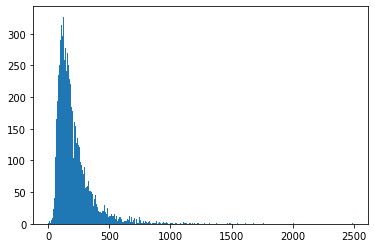

In [ ]:
# For determining size of input...

# Making histogram for no of words in news shows that most news article are under 700 words.
# Lets keep each news small and truncate all news to 700 while tokenizing
plt.hist([len(x) for x in X], bins=500)
plt.show()

# Its heavily skewed. There are news with 5000 words? Lets truncate these outliers :) 

In [ ]:
nos = np.array([len(x) for x in X])
len(nos[nos  < 700])
# Out of 48k news, 44k have less than 700 words

11211

In [ ]:
#Lets keep all news to 700, add padding to news with less than 700 words and truncating long ones
maxlen = 700 

#Making all news of size maxlen defined above
X = pad_sequences(X, maxlen=maxlen)

In [ ]:
#all news has 700 words (in numerical form now). If they had less words, they have been padded with 0
# 0 is not associated to any word, as mapping of words started from 1
# 0 will also be used later, if unknows word is encountered in test set
len(X[0])

700

In [ ]:
# Adding 1 because of reserved 0 index
# Embedding Layer creates one more vector for "UNKNOWN" words, or padded words (0s). This Vector is filled with zeros.
# Thus our vocab size inceeases by 1
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
# Function to create weight matrix from word2vec gensim model
def get_weight_matrix(model, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        weight_matrix[i] = model[word]
    return weight_matrix

We Create a matrix of mapping between word-index and vectors. We use this as weights in embedding layer

Embedding layer accepts numecical-token of word and outputs corresponding vercor to inner layer.

It sends vector of zeros to next layer for unknown words which would be tokenized to 0.


Input length of Embedding Layer is the length of each news (700 now due to padding and truncating)

In [ ]:
#Getting embedding vectors from word2vec and usings it as weights of non-trainable keras embedding layer
embedding_vectors = get_weight_matrix(w2v_model, word_index)

KeyError: ignored

In [ ]:
#Defining Neural Network
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_vectors], input_length=maxlen, trainable=False))
#LSTM 
model.add(LSTM(units=128))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

del embedding_vectors

In [ ]:
model.summary()

In [ ]:
#Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y) 

In [ ]:
model.fit(X_train, y_train, validation_split=0.3, epochs=6)

In [ ]:
#Prediction is in probability of news being real, so converting into classes
# Class 0 (Fake) if predicted prob < 0.5, else class 1 (Real)
y_pred = (model.predict(X_test) >= 0.5).astype("int")

In [ ]:
accuracy_score(y_test, y_pred)

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
del model

### Using Pre-Trained Word2Vec Vectors

**Needs 12GB RAM and 4GB HardDisk Space **

Now, instead of creating word vectors, let us use pre-trained vectors trained on part of **Google News dataset** (about 100 billion words). The model contains 300-dimensional vectors for 3 million words and phrases.  Source: https://code.google.com/archive/p/word2vec/

**Please download model file from**: https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?usp=sharing


Or add Dataset from https://www.kaggle.com/sandreds/googlenewsvectorsnegative300


In [ ]:
#invoke garbage collector to free ram
import gc
gc.collect()

36518

In [ ]:
from gensim.models.keyedvectors import KeyedVectors

In [ ]:
# Takes RAM 
word_vectors = KeyedVectors.load_word2vec_format('/content/drive/MyDrive/research/word2vec.txt')
EMBEDDING_DIM=100

### Exploring these trained Vectors

In [ ]:
word_vectors.most_similar('বাংলাদেশ')

[("'বাংলাদেশ", 0.7342807650566101),
 ('বাংলদেশ', 0.7298583984375),
 ('বংলাদেশ', 0.7064653038978577),
 ('বিশ্ব', 0.6834918260574341),
 ('জাপান', 0.6717811822891235),
 ('এশিয়ান', 0.6656081080436707),
 ('বাংলাদেশের', 0.6640017628669739),
 ('জাতীয়', 0.65651935338974),
 ('পাকিস্তান', 0.6507294774055481),
 ('ভারত', 0.639733612537384)]

In [ ]:
# word_vectors.most_similar('fbi')

In [ ]:
# word_vectors.most_similar('Republic')

In [ ]:
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
    try:
        embedding_vector = word_vectors[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        embedding_matrix[i]=np.random.normal(0,np.sqrt(0.25),EMBEDDING_DIM)

#del word_vectors

In [ ]:
#Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y) 

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_matrix], input_length=maxlen, trainable=False))
model.add(Conv1D(activation='relu', filters=4, kernel_size=4))
model.add(MaxPool1D())
model.add(LSTM(units=128))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

del embedding_matrix

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 700, 100)          12547600  
_________________________________________________________________
conv1d (Conv1D)              (None, 697, 4)            1604      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 348, 4)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 128)               68096     
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 12,617,429
Trainable params: 69,829
Non-trainable params: 12,547,600
_________________________________________________________________


In [ ]:
model.fit(X_train, y_train, validation_split=0.3, epochs=12)

Epoch 1/12
188/188 [==============================] - 38s 24ms/step - loss: 0.2578 - acc: 0.8919 - val_loss: 0.2269 - val_acc: 0.9164
Epoch 2/12
188/188 [==============================] - 4s 22ms/step - loss: 0.2008 - acc: 0.9189 - val_loss: 0.1972 - val_acc: 0.9273
Epoch 3/12
188/188 [==============================] - 4s 22ms/step - loss: 0.1778 - acc: 0.9299 - val_loss: 0.1793 - val_acc: 0.9285
Epoch 4/12
188/188 [==============================] - 4s 22ms/step - loss: 0.1567 - acc: 0.9365 - val_loss: 0.1724 - val_acc: 0.9304
Epoch 5/12
188/188 [==============================] - 4s 22ms/step - loss: 0.1449 - acc: 0.9427 - val_loss: 0.1678 - val_acc: 0.9335
Epoch 6/12
188/188 [==============================] - 4s 22ms/step - loss: 0.1284 - acc: 0.9484 - val_loss: 0.1723 - val_acc: 0.9355
Epoch 7/12
188/188 [==============================] - 4s 22ms/step - loss: 0.1259 - acc: 0.9508 - val_loss: 0.1917 - val_acc: 0.9343
Epoch 8/12
188/188 [==============================] - 4s 22ms/step -

In [ ]:
y_pred = (model.predict(X_test) > 0.5).astype("int")

In [ ]:
accuracy_score(y_test, y_pred)

Confusion Matrix: 
 [[ 249  103]
 [  75 2432]]


In [ ]:
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix: \n", cm)

CM not normalized


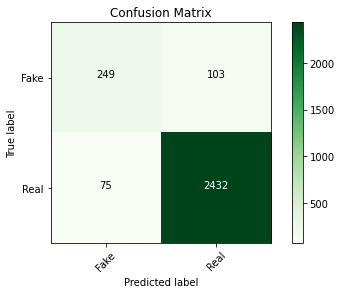

In [ ]:
# Plot Confusion Matrix
plot_confusion_matrix(cm,classes = ['Fake','Real'])

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.71      0.74       352
           1       0.96      0.97      0.96      2507

    accuracy                           0.94      2859
   macro avg       0.86      0.84      0.85      2859
weighted avg       0.94      0.94      0.94      2859



**Do Upvote if you find this notebook useful.**

**Thanks**